In [1]:
import pandas as pd
import random
!pip install transformers datasets torch --quiet
import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import re
from sklearn.utils import resample

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [7]:
result = pd.read_csv("/content/big_data.csv")

In [6]:
# Display unique labels in the 'label' column
unique_labels = result['label'].unique()
print("Unique labels in the 'label' column:")
print(unique_labels)

# Count occurrences of each label, including NaN
label_counts = result['label'].value_counts(dropna=False)

# Combine 'Health and Lifestyle' and 'Health and lifestyle'
result['label'] = result['label'].replace({
    'Health and lifestyle': 'Health and Lifestyle'
})

# Recount occurrences after cleaning
label_counts_cleaned = result['label'].value_counts(dropna=False)

# Display the counts
print("Count of each label in the 'label' column:")
print(label_counts_cleaned)

Unique labels in the 'label' column:
['Tech' 'Food' 'Health and Lifestyle' 'Travel' 'Sports' 'Fashion'
 'Health and lifestyle' 'Entertainment' 'Mom and Children' 'Art' nan
 'Gaming']
Count of each label in the 'label' column:
label
Health and Lifestyle    19634
Food                    18606
Entertainment           12931
Tech                    12825
Fashion                 11143
Travel                  10544
Art                      7485
Mom and Children         5471
Sports                   4482
Gaming                    630
NaN                       247
Name: count, dtype: int64


#GRAPHS

In [ ]:
result_2 = result.copy()

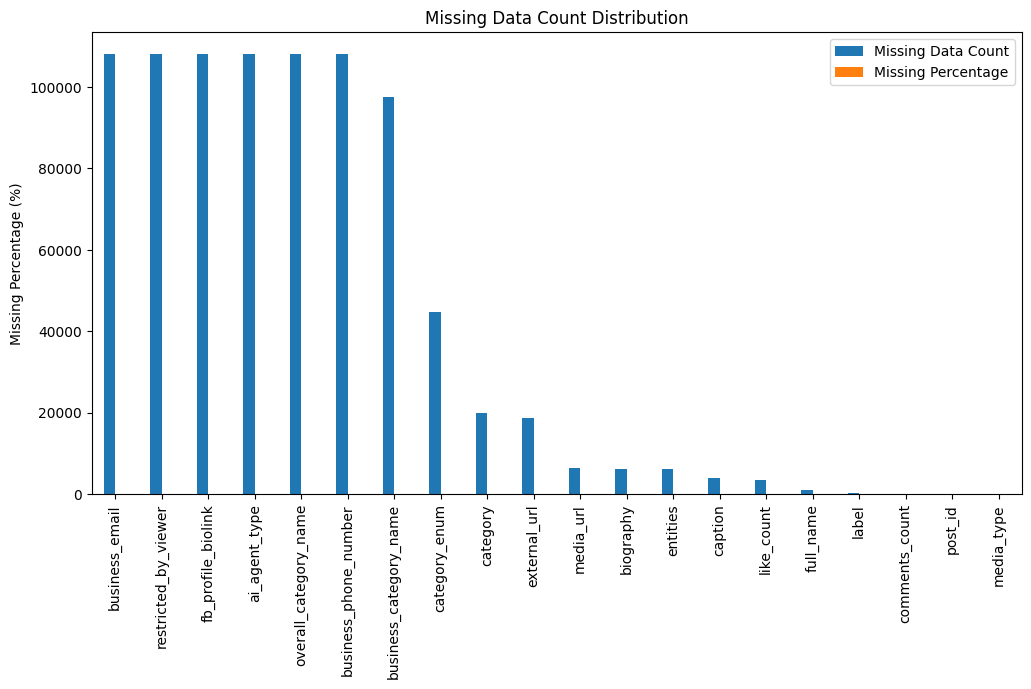

                        Missing Data Count  Missing Percentage
business_email                      108066          100.000000
restricted_by_viewer                108066          100.000000
fb_profile_biolink                  108066          100.000000
ai_agent_type                       108066          100.000000
overall_category_name               108066          100.000000
business_phone_number               108066          100.000000
business_category_name               97567           90.284641
category_enum                        44756           41.415431
category                             19870           18.386912
external_url                         18685           17.290360
media_url                             6515            6.028723
biography                             6117            5.660430
entities                              6117            5.660430
caption                               3853            3.565414
like_count                            3530            3

In [ ]:
missing_data = result_2.isnull().sum()
missing_percentage = (missing_data / len(result_2)) * 100

missing_info = pd.DataFrame({'Missing Data Count': missing_data, 'Missing Percentage': missing_percentage})
missing_info = missing_info[missing_info['Missing Percentage'] > 0].sort_values(by='Missing Percentage', ascending=False)

missing_info.plot(kind='bar', figsize=(12, 6))
plt.title('Missing Data Count Distribution')
plt.ylabel('Missing Percentage (%)')
plt.show()

print(missing_info)

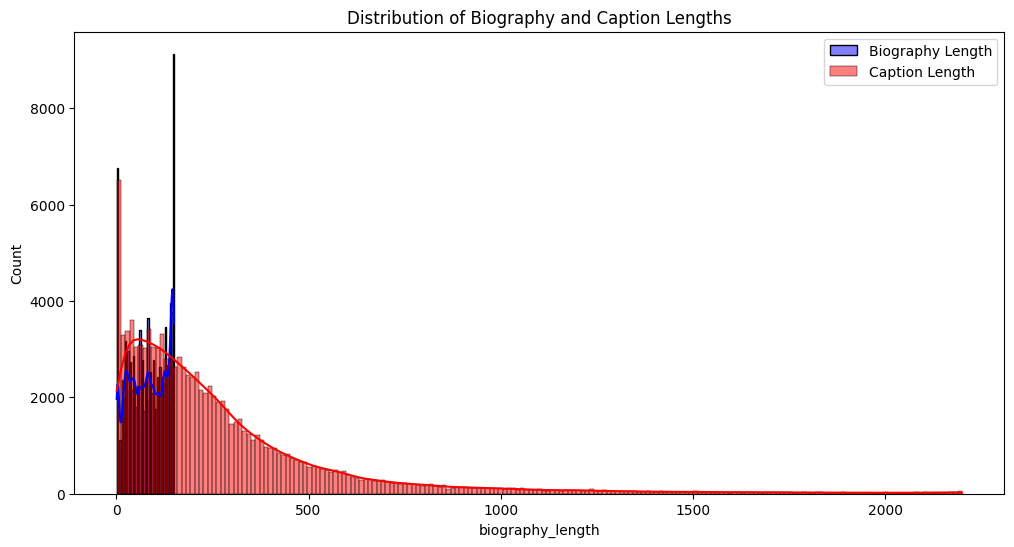

In [ ]:
# Calculate the lengths of Biography and Caption
result_2['biography_length'] = result_2['biography'].apply(lambda x: len(str(x)))
result_2['caption_length'] = result_2['caption'].apply(lambda x: len(str(x)))

# Visualize the distribution of lengths
plt.figure(figsize=(12, 6))
sns.histplot(result_2['biography_length'], kde=True, color='blue', label='Biography Length')
sns.histplot(result_2['caption_length'], kde=True, color='red', label='Caption Length')
plt.title('Distribution of Biography and Caption Lengths')
plt.legend()
plt.show()


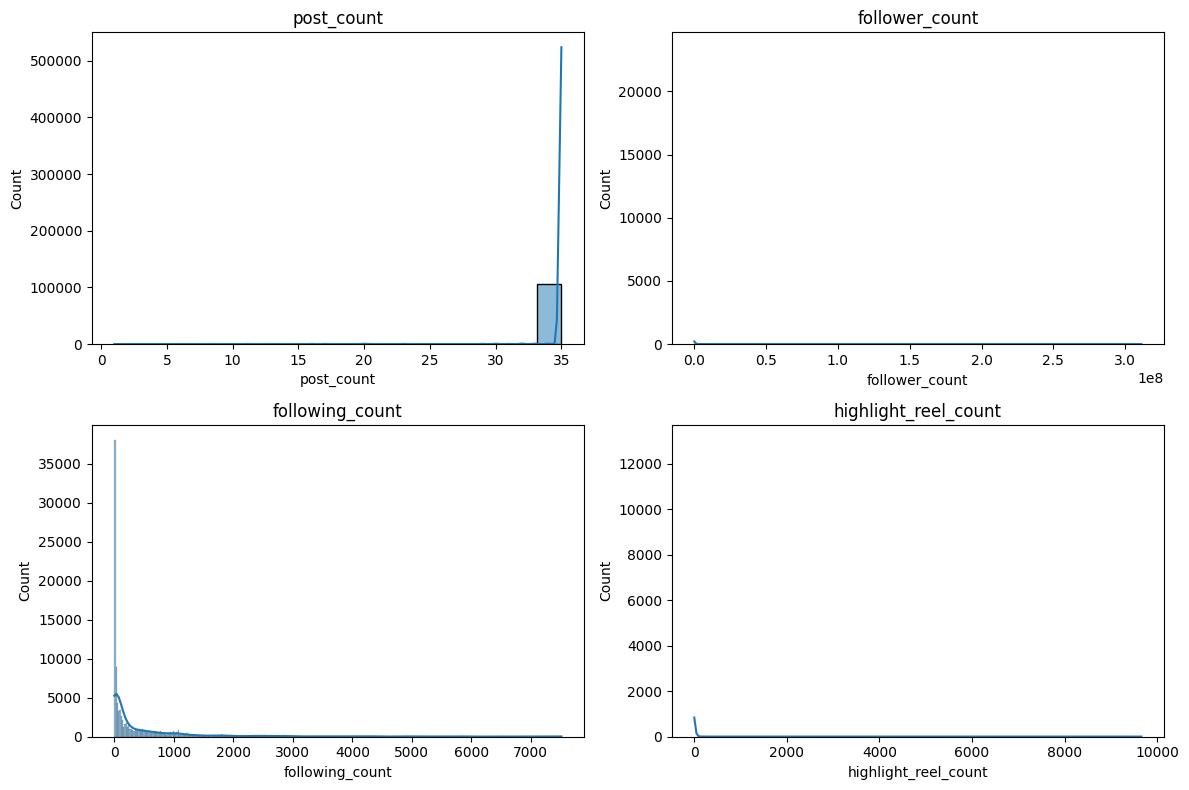

In [ ]:
numerical_features = ['post_count', 'follower_count', 'following_count', 'highlight_reel_count']
result_2[numerical_features].describe()


plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(result_2[feature], kde=True)
    plt.title(f'{feature}')

plt.tight_layout()
plt.show()


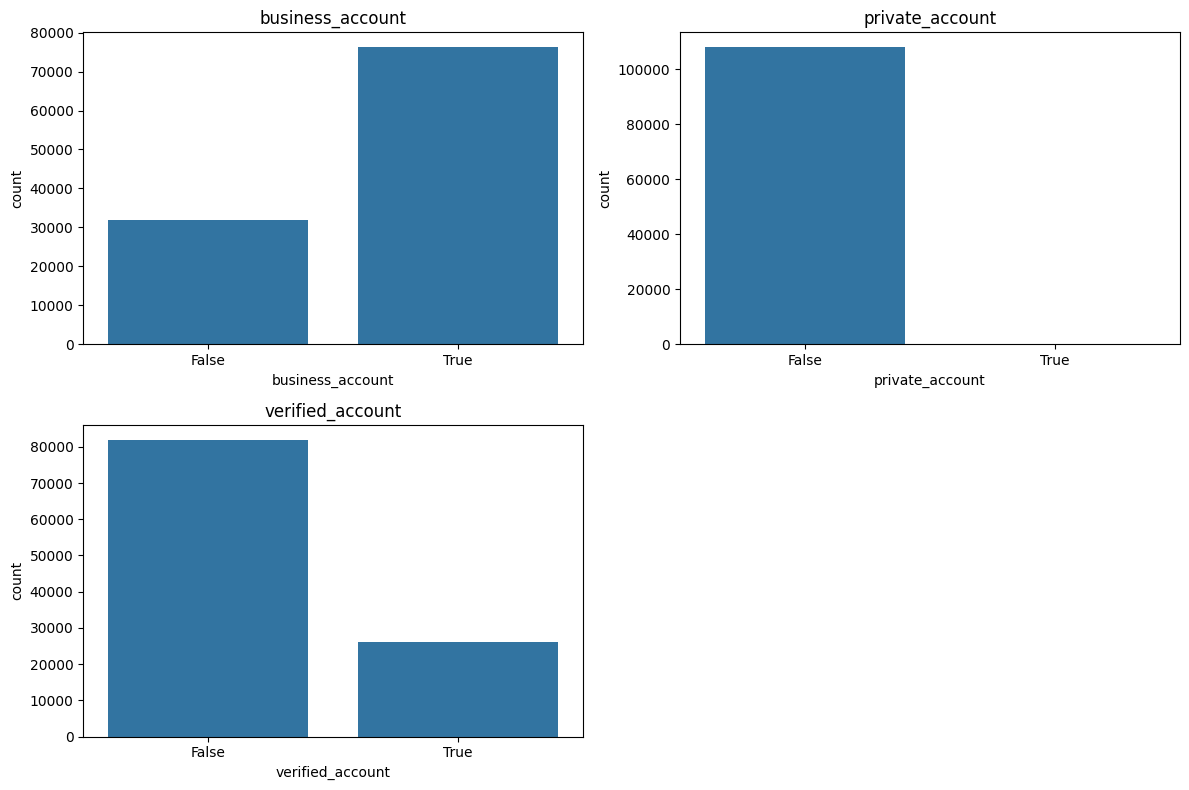

In [ ]:
categorical_features = ['business_account', 'private_account', 'verified_account']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=result_2, x=feature)
    plt.title(f'{feature}')

plt.tight_layout()
plt.show()


       bio_links_count  external_url_count
count    108066.000000            108066.0
mean          4.152786                 1.0
std           2.597901                 0.0
min           1.000000                 1.0
25%           4.000000                 1.0
50%           4.000000                 1.0
75%           4.000000                 1.0
max          20.000000                 1.0


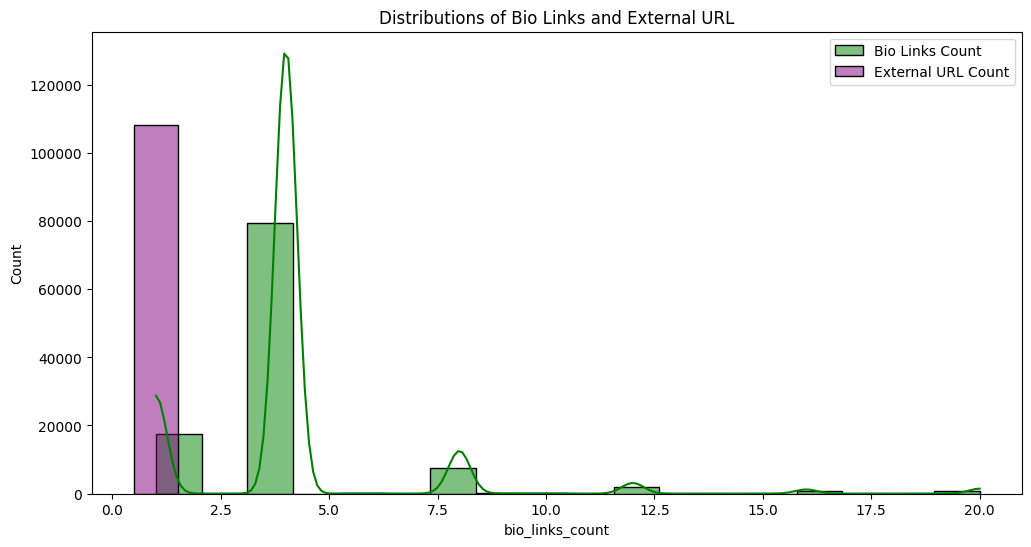

In [ ]:
# Analyze the distribution of bio links and external URL features
result_2['bio_links_count'] = result_2['bio_links'].apply(lambda x: len(str(x).split(',')) if x else 0)
result_2['external_url_count'] = result_2['external_url'].apply(lambda x: 1 if x else 0)

# Print the statistics of these features
print(result_2[['bio_links_count', 'external_url_count']].describe())

# Visualize the distributions
plt.figure(figsize=(12, 6))
sns.histplot(result_2['bio_links_count'], kde=True, color='green', label='Bio Links Count')
sns.histplot(result_2['external_url_count'], kde=True, color='purple', label='External URL Count')
plt.title('Distributions of Bio Links and External URL')
plt.legend()
plt.show()


#MODEL (Deniz buba buradan itibaren)

In [8]:
#Buba ilk cell
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import re
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
!pip install emoji
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 10.7 MB/s eta 0:00:00


In [9]:
#Buba ikinci cell


# Remove rows with NaN values in the 'label' column
result = result[result['label'].notna()]

# Separate majority and minority classes
majority = result[result['label'] != 'Gaming']
minority = result[result['label'] == 'Gaming']

# Oversample the minority class
minority_oversampled = resample(minority,
                                replace=True,  # Allow resampling with replacement
                                n_samples=len(majority) // 22,  # Adjust sample size as needed
                                random_state=42)

# Combine back into a single dataset
df_balanced = pd.concat([majority, minority_oversampled])

# Reset index to prevent index conflicts
df_balanced.reset_index(drop=True, inplace=True)

# Handle NaN values
df_balanced.fillna('', inplace=True)

# Select numerical and categorical features
numerical_features = ['follower_count', 'following_count', 'post_count', 'like_count']
categorical_features = ['verified_account', 'business_account', 'is_professional_account']

# Ensure numerical features are numeric and handle NaN
df_balanced[numerical_features] = df_balanced[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)

# Normalize numerical features
scaler = MinMaxScaler()
df_balanced[numerical_features] = scaler.fit_transform(df_balanced[numerical_features])

# One-hot encode categorical features
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(df_balanced[categorical_features]).toarray()

# Create a DataFrame for encoded features and reset index
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))
encoded_categorical_df.reset_index(drop=True, inplace=True)

# Combine original and encoded categorical features
df_balanced.reset_index(drop=True, inplace=True)  # Ensure the original DataFrame has a clean index
df_balanced = pd.concat([df_balanced, encoded_categorical_df], axis=1)

# Encode labels
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['label'])

<ipython-input-9-75fe9f026316>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_balanced.fillna('', inplace=True)


In [10]:
#Buba üçüncü cell

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset
df = df_balanced  # Ensure 'df_balanced' is loaded before running this code

# Handle NaN in numerical features
df[numerical_features] = df[numerical_features].fillna(0)  # Replace NaN in numerical columns with 0
df['caption'] = df['caption'].fillna('')  # Replace NaN in the 'caption' column with empty strings
df['biography'] = df['biography'].fillna('')  # Replace NaN in the 'biography' column with empty strings

# Combine captions and biography
df['Bio_Caption'] = df['caption'] + ' ' + df['biography']

# Define Turkish stopwords (manually or from a library)
turkish_stopwords = set([
    'bir', 'olarak', 'olsun', 'olan', 'yeni', 'kadar', 'iyi', 'özel', 'bilgi',
    'devam', 'kutlu', 'büyük', 'güzel', 'var', 'ilk', 'son', 'sonra', 'yer',
    'zaman', 'bugün', 'teşekkür', 'ziyaret', 'gün', 'günü', 'birlikte',
    'kasım', 'ekim', 'yıl', 'istanbul', 'türkiye', 'izmir', 'mustafa','kemal',
    'cumhuriyet','cumhuriyetimizin', 'sadece','tarafından','fazla','atatürk',
    'şekilde', 'saat','olmak','detaylı','mi'
])

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Combine stopwords
custom_stopwords = turkish_stopwords.union({
    'the', 'and', 'of', 'to', 'a', 'in', 'with', 'for', 'is', 'you', 'we',
    'at', 'our', 'your'
})
all_stopwords = english_stopwords.union(custom_stopwords)

# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Function to preprocess text
def preprocess_text(text):
    # Remove emojis
    text = remove_emojis(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in all_stopwords]
    return ' '.join(words)

# Apply text preprocessing
df['Bio_Caption'] = df['Bio_Caption'].apply(preprocess_text)
#Drop unneccessary columns
df.drop(['biography', 'caption'], axis=1, inplace=True)

# Define the list of columns you want to keep
"""selected_columns = [
    'username',
    'Bio_Caption',
    'verified_account_True',
    'verified_account_False',
    'business_account_False',
    'business_account_True',
    'is_professional_account_True',
    'is_professional_account_False',
    'follower_count',
    'following_count',
    'post_count',
    'like_count',
    'verified_account',
    'business_account',
    'is_professional_account',
    'label'
]

# Keep only the selected columns in the DataFrame
filtered_data = df[selected_columns]"""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


"selected_columns = [\n    'username',\n    'Bio_Caption',\n    'verified_account_True',\n    'verified_account_False',\n    'business_account_False',\n    'business_account_True',\n    'is_professional_account_True',\n    'is_professional_account_False',\n    'follower_count',\n    'following_count',\n    'post_count',\n    'like_count',\n    'verified_account',\n    'business_account',\n    'is_professional_account',\n    'label'\n]\n\n# Keep only the selected columns in the DataFrame\nfiltered_data = df[selected_columns]"

In [11]:
# ha bunu da çaliştir bakem

# Load pre-trained DistilBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Bio_Caption'], df['label'], test_size=0.2, random_state=42
)

train_features = df.loc[train_texts.index, numerical_features + list(encoded_categorical_df.columns)]
test_features = df.loc[test_texts.index, numerical_features + list(encoded_categorical_df.columns)]

train_features = df.loc[train_texts.index, numerical_features + list(encoded_categorical_df.columns)]
test_features = df.loc[test_texts.index, numerical_features + list(encoded_categorical_df.columns)]



################################################################### TRIAL-2 08.01.2024 ###################################################################3
# Dataset class
class HybridDataset(Dataset):
    def __init__(self, texts, labels, features):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.features = features
        self.encodings = tokenizer(self.texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "features": torch.tensor(self.features.iloc[idx].values, dtype=torch.float),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = HybridDataset(train_texts, train_labels, train_features)

test_dataset = HybridDataset(test_texts, test_labels, test_features)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=16)

# Define model with DistilBERT and additional features
class HybridClassifier(nn.Module):
    def __init__(self, distilbert, num_classes, feature_dim):
        super(HybridClassifier, self).__init__()
        self.distilbert = distilbert
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, features):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        feature_output = self.feature_layer(features)
        combined = torch.cat((pooled_output, feature_output), dim=1)
        logits = self.classifier(combined)
        return logits

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
feature_dim = train_features.shape[1]
model = HybridClassifier(distilbert, num_classes, feature_dim).to(device)

# Optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/5"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")



# Test loop
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        test_loss += criterion(logits, labels).item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader)}, Accuracy: {correct / total}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training Epoch 1/5:   0%|          | 3/5391 [00:55<27:46:04, 18.55s/it]


KeyboardInterrupt: 

In [30]:
merged_data_path = "/content/merged_data.csv"
classification_data_path = "/content/test-classification-round3.csv"

merged_data = pd.read_csv(merged_data_path)
classification_data = pd.read_csv(classification_data_path)

test_data = pd.merge(merged_data, classification_data, on="username", how="outer")

In [27]:
# Fill NaN values with specific defaults for 'caption' and 'biography'
test_data['caption'] = test_data['caption'].fillna('')
test_data['biography'] = test_data['biography'].fillna('')

# Fill NaN values with 0 for all other columns
test_data = test_data.fillna(0, downcast=None, inplace=False, limit=None)

# Ensure the columns are strings for 'caption' and 'biography'
test_data['caption'] = test_data['caption'].astype(str)
test_data['biography'] = test_data['biography'].astype(str)

<ipython-input-27-6e49df1dda70>:6: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  test_data = test_data.fillna(0, downcast=None, inplace=False, limit=None)


In [31]:
test_data

,username,user_id,full_name,biography,category,post_count,follower_count,following_count,business_account,private_account,...,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,caption,comments_count,post_id,like_count,media_type,media_url
0,01burdaavm,2000935996,01 Burda AVM,🎁Yılbaşı Alışverişlerin Shopla ile Kazandırıyor!🎄,Blogger,35,34861,14,True,False,...,NaN,False,False,https://instagram.fyei1-1.fna.fbcdn.net/v/t51....,Lezzetini doğallıktan alan yöresel tatlar burd...,0.0,1.800475e+16,16.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...
1,01burdaavm,2000935996,01 Burda AVM,🎁Yılbaşı Alışverişlerin Shopla ile Kazandırıyor!🎄,Blogger,35,34861,14,True,False,...,NaN,False,False,https://instagram.fyei1-1.fna.fbcdn.net/v/t51....,Sonbaharın büyüsünü yansıtan kupa ve termoslar...,20.0,1.802766e+16,18.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...
2,01burdaavm,2000935996,01 Burda AVM,🎁Yılbaşı Alışverişlerin Shopla ile Kazandırıyor!🎄,Blogger,35,34861,14,True,False,...,NaN,False,False,https://instagram.fyei1-1.fna.fbcdn.net/v/t51....,"Geleceğe yön veren, bir asırlık görüş ile müca...",0.0,1.801850e+16,28.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...
3,01burdaavm,2000935996,01 Burda AVM,🎁Yılbaşı Alışverişlerin Shopla ile Kazandırıyor!🎄,Blogger,35,34861,14,True,False,...,NaN,False,False,https://instagram.fyei1-1.fna.fbcdn.net/v/t51....,"Bir asır boyunca yorulmadan, azim ve cesaretle...",0.0,1.800438e+16,26.0,IMAGE,https://scontent-sof1-2.cdninstagram.com/v/t39...
4,01burdaavm,2000935996,01 Burda AVM,🎁Yılbaşı Alışverişlerin Shopla ile Kazandırıyor!🎄,Blogger,35,34861,14,True,False,...,NaN,False,False,https://instagram.fyei1-1.fna.fbcdn.net/v/t51....,"Bir asır boyunca yorulmadan, azim ve cesaretle...",1.0,1.787530e+16,25.0,IMAGE,https://scontent-sof1-1.cdninstagram.com/v/t39...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187297,zynp_odnc,3663117432,Zeynep Oduncu,Parlementera Êlihê ya Partiya Wekhevî û Demokr...,Politician,35,3176,618,False,False,...,NaN,False,False,https://instagram.fdnz1-1.fna.fbcdn.net/v/t51....,6. Olağanüstü Kongremiz öncesinde Amed’de halk...,0.0,1.798776e+16,164.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...
187298,zynp_odnc,3663117432,Zeynep Oduncu,Parlementera Êlihê ya Partiya Wekhevî û Demokr...,Politician,35,3176,618,False,False,...,NaN,False,False,https://instagram.fdnz1-1.fna.fbcdn.net/v/t51....,"Beriya kongreya giştî ya partiya me, em ê li A...",0.0,1.809570e+16,75.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...
187299,zynp_odnc,3663117432,Zeynep Oduncu,Parlementera Êlihê ya Partiya Wekhevî û Demokr...,Politician,35,3176,618,False,False,...,NaN,False,False,https://instagram.fdnz1-1.fna.fbcdn.net/v/t51....,32 aydır İmralı Cezaevinde mutlak iletişimsizl...,0.0,1.839197e+16,139.0,CAROUSEL_ALBUM,https://scontent-sof1-1.cdninstagram.com/v/t51...
187300,zynp_odnc,3663117432,Zeynep Oduncu,Parlementera Êlihê ya Partiya Wekhevî û Demokr...,Politician,35,3176,618,False,False,...,NaN,False,False,https://instagram.fdnz1-1.fna.fbcdn.net/v/t51....,6 Şubat 2023 depremi üzerinden 9 ay geçmiş olm...,1.0,1.801388e+16,157.0,VIDEO,https://scontent-sof1-2.cdninstagram.com/o1/v/...


In [ ]:
#Buba bu da son cell.

# Load the unfiltered test dataset
#unfiltered_test_path = " "  # Provide the test dataset path
#test_data = pd.read_csv(unfiltered_test_path)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Define Turkish stopwords
turkish_stopwords = set([
    'bir', 'olarak', 'olsun', 'olan', 'yeni', 'kadar', 'iyi', 'özel', 'bilgi',
    'devam', 'kutlu', 'büyük', 'güzel', 'var', 'ilk', 'son', 'sonra', 'yer',
    'zaman', 'bugün', 'teşekkür', 'ziyaret', 'gün', 'günü', 'birlikte',
    'kasım', 'ekim', 'yıl', 'istanbul', 'türkiye', 'izmir', 'mustafa', 'kemal',
    'cumhuriyet', 'cumhuriyetimizin', 'sadece', 'tarafından', 'fazla', 'atatürk',
    'şekilde', 'saat', 'olmak', 'detaylı', 'mi'
])

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Combine stopwords
custom_stopwords = turkish_stopwords.union({
    'the', 'and', 'of', 'to', 'a', 'in', 'with', 'for', 'is', 'you', 'we',
    'at', 'our', 'your'
})
all_stopwords = english_stopwords.union(custom_stopwords)

# Function to remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

# Function to preprocess text
def preprocess_text(text):
    # Remove emojis
    text = remove_emojis(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in all_stopwords]
    return ' '.join(words)

# Preprocess the test dataset
def preprocess_test_data(df):
    # Fill NaN values in textual columns
    df['caption'] = df['caption'].fillna('')
    df['biography'] = df['biography'].fillna('')

    # Combine captions and biography
    df['Bio_Caption'] = df['caption'] + ' ' + df['biography']

    # Apply text preprocessing
    df['Bio_Caption'] = df['Bio_Caption'].apply(preprocess_text)

    # Define numerical and categorical features
    numerical_features = ['follower_count', 'following_count', 'post_count', 'like_count']
    categorical_features = ['verified_account', 'business_account', 'is_professional_account']

    # Ensure numerical features are numeric and handle NaN
    df[numerical_features] = df[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Normalize numerical features
    df[numerical_features] = scaler.transform(df[numerical_features])

    # One-hot encode categorical features
    encoded_categorical = encoder.transform(df[categorical_features]).toarray()
    encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))
    encoded_categorical_df.reset_index(drop=True, inplace=True)

    # Combine original and encoded features
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, encoded_categorical_df], axis=1)

    return df

# Apply preprocessing to the test dataset
test_data = preprocess_test_data(test_data)

# Define the test dataset class
class TestDataset(Dataset):
    def __init__(self, texts, features):
        self.texts = texts.tolist()
        self.features = features
        self.encodings = tokenizer(self.texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "features": torch.tensor(self.features.iloc[idx].values, dtype=torch.float),
        }

# Initialize the test dataset and dataloader
test_texts = test_data['Bio_Caption']
test_features = test_data.drop(columns=['username', 'Bio_Caption', 'caption', 'biography'])

test_dataset = TestDataset(test_texts, test_features)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Perform inference
model.eval()
label_encoder_classes = label_encoder.classes_
predictions = {}

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Map predictions to usernames
        batch_usernames = test_data.iloc[i * test_loader.batch_size: (i + 1) * test_loader.batch_size]['username']
        for username, pred in zip(batch_usernames, preds):
            predictions[username] = label_encoder_classes[pred]

# Save predictions to a JSON file
output_path = "/content/predicted_labels.json"
with open(output_path, "w") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)

print(f"Predictions saved to {output_path}")

###First

In [ ]:
# Dataset class
class HybridDataset(Dataset):
    def __init__(self, texts, labels, features):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.features = features
        self.encodings = tokenizer(self.texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "features": torch.tensor(self.features.iloc[idx].values, dtype=torch.float),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = HybridDataset(train_texts, train_labels, train_features)

test_dataset = HybridDataset(test_texts, test_labels, test_features)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=16)

# Define model with DistilBERT and additional features
class HybridClassifier(nn.Module):
    def __init__(self, distilbert, num_classes, feature_dim):
        super(HybridClassifier, self).__init__()
        self.distilbert = distilbert
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, features):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        feature_output = self.feature_layer(features)
        combined = torch.cat((pooled_output, feature_output), dim=1)
        logits = self.classifier(combined)
        return logits

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
feature_dim = train_features.shape[1]
model = HybridClassifier(distilbert, num_classes, feature_dim).to(device)

# Optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/5"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")



# Test loop
model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        test_loss += criterion(logits, labels).item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader)}, Accuracy: {correct / total}")

Training Epoch 1/5: 100%|██████████| 5391/5391 [16:14<00:00,  5.53it/s]


Epoch 1 Loss: 0.8500901371450686


Training Epoch 2/5: 100%|██████████| 5391/5391 [16:18<00:00,  5.51it/s]


Epoch 2 Loss: 0.3670118220436467


Training Epoch 3/5: 100%|██████████| 5391/5391 [16:18<00:00,  5.51it/s]


Epoch 3 Loss: 0.24191712418460898


Training Epoch 4/5: 100%|██████████| 5391/5391 [16:20<00:00,  5.50it/s]


Epoch 4 Loss: 0.15846834916105146


Training Epoch 5/5: 100%|██████████| 5391/5391 [16:19<00:00,  5.50it/s]


Epoch 5 Loss: 0.10039254626814248
Test Loss: 0.4279260457885144, Accuracy: 0.8865596883405992


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "hybrid_classifier_model.pth")
from google.colab import files

# Save and then download the model
files.download("hybrid_classifier_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#TEST PART

In [ ]:
class HybridClassifier(nn.Module):
    def __init__(self, distilbert, num_classes, feature_dim):
        super(HybridClassifier, self).__init__()
        self.distilbert = distilbert
        self.feature_layer = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, features):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)
        feature_output = self.feature_layer(features)
        combined = torch.cat((pooled_output, feature_output), dim=1)
        logits = self.classifier(combined)
        return logits

# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [ ]:
#When you want to use the trained model again, you can load the saved weights back into the model using model.load_state_dict():
from transformers import DistilBertModel

# Initialize DistilBERT model
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Set the number of classes (you can adjust this based on your dataset)
num_classes = 10  # Update with the actual number of classes in your dataset

# Set the feature dimension (this should match the number of features in your dataset)
feature_dim = 10  # Update with the actual number of features in your dataset

# Initialize the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model first
model = HybridClassifier(distilbert, num_classes, feature_dim).to(device)

# Load the saved weights into the model
model.load_state_dict(torch.load("hybrid_classifier_model.pth"))

# Set the model to evaluation mode
model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-3-a81bbee128a1>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_classifier_model.pth"))


HybridClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [ ]:
# Load the dataset
test_dataset = pd.read_csv("/content/classificationround2.csv")

# Inspect the dataset structure
print(test_dataset.columns)


Index(['username', 'user_id', 'full_name', 'biography', 'category',
       'post_count', 'follower_count', 'following_count', 'business_account',
       'private_account', 'verified_account', 'highlight_reel_count',
       'bio_links', 'entities', 'ai_agent_type', 'fb_profile_biolink',
       'restricted_by_viewer', 'country_block', 'eimu_id', 'external_url',
       'fbid', 'has_clips', 'hide_like_and_view_counts',
       'is_professional_account', 'is_supervision_enabled',
       'is_guardian_of_viewer', 'is_supervised_by_viewer',
       'is_supervised_user', 'is_embeds_disabled', 'is_joined_recently',
       'business_address', 'business_contact_method', 'business_email',
       'business_phone_number', 'business_category_name',
       'overall_category_name', 'category_enum', 'is_verified_by_mv4b',
       'is_regulated_c18', 'profile_pic_url', 'caption', 'comments_count',
       'post_id', 'like_count', 'media_type', 'media_url'],
      dtype='object')


Aşağıdaki kod bloğunu çalıştırmadan önce yukarıdaki "MODEL" başlığının altındaki " This cell is used for both at training and testing part. It is crucial" adlı bloğu çalıştır.

In [ ]:
# Preprocess test_dataset (ensure same preprocessing as training)
test_dataset['caption'] = test_dataset['caption'].fillna('')  # Replace NaN in the 'caption' column with empty strings
test_dataset['biography'] = test_dataset['biography'].fillna('')  # Replace NaN in the 'biography' column with empty strings

# Combine captions and biography
test_dataset['Bio_Caption'] = test_dataset['caption'] + ' ' + test_dataset['biography']

# Remove emojis from the combined text
test_dataset['Bio_Caption'] = test_dataset['Bio_Caption'].apply(remove_emojis)

# Handle numerical and categorical features
numerical_features = ['follower_count', 'following_count', 'post_count', 'like_count']
categorical_features = ['verified_account', 'business_account', 'is_professional_account']

test_dataset[numerical_features] = test_dataset[numerical_features].fillna(0)  # Replace NaN in numerical columns with 0
test_dataset[numerical_features] = test_dataset[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)  # Ensure numeric

scaler = MinMaxScaler()
# Normalize numerical features using the same scaler
test_dataset[numerical_features] = scaler.fit_transform(test_dataset[numerical_features])

# One-hot encode categorical features using the same encoder
encoder = OneHotEncoder()
encoded_categorical_test = encoder.fit_transform(test_dataset[categorical_features]).toarray()
encoded_categorical_test_df = pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_features))

# Combine numerical, categorical features, and text data
test_features = pd.concat([test_dataset[numerical_features].reset_index(drop=True),
                           pd.DataFrame(encoded_categorical_test, columns=encoder.get_feature_names_out(categorical_features))], axis=1)

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Create Dataset class for test data
class TestHybridDataset(Dataset):
    def __init__(self, texts, features):
        self.texts = texts.tolist()
        self.features = features
        self.encodings = tokenizer(self.texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "features": torch.tensor(self.features.iloc[idx].values, dtype=torch.float)
        }

# Prepare test dataset and dataloader
test_dataset_object = TestHybridDataset(test_dataset['Bio_Caption'], test_features)
test_loader = DataLoader(test_dataset_object, batch_size=16)

# Predict labels for the test_dataset
predicted_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        preds = torch.argmax(logits, dim=1)
        predicted_labels.extend(preds.cpu().numpy())

# Convert predicted labels back to their original class names
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Add the predicted labels to the test_dataset
test_dataset['predicted_label'] = predicted_labels

import json

# Assuming 'username' column exists in test_dataset and contains the usernames

# Create a dictionary with 'username' as keys and 'predicted_label' as values
predicted_dict = dict(zip(test_dataset['username'], test_dataset['predicted_label']))

# Convert the dictionary to JSON format
json_data = json.dumps(predicted_dict, indent=4)

# Save the JSON data to a file
with open('predicted_labels.json', 'w') as json_file:
    json_file.write(json_data)

print("Results have been saved as predicted_labels.json")



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x9 and 10x64)

In [ ]:
print(f"input_ids shape: {input_ids.shape}")
print(f"attention_mask shape: {attention_mask.shape}")
print(f"features shape: {features.shape}")


input_ids shape: torch.Size([16, 128])
attention_mask shape: torch.Size([16, 128])
features shape: torch.Size([16, 9])


##ROUND1

In [ ]:
if 'predicted_label' in test_dataset.columns:
    unique_labels = test_dataset['predicted_label'].unique()
    print(unique_labels)
else:
    print("The 'label' column is not present in the test dataset.")


['Tech' 'Health and Lifestyle' 'Sports' 'Food' 'Fashion' 'Entertainment'
 'Travel' 'Mom and Children' 'Art' 'Gaming']


In [ ]:
if 'predicted_label' in test_dataset.columns:
    label_counts = test_dataset['predicted_label'].value_counts()
    print(label_counts)
else:
    print("The 'label' column is not present in the test dataset.")


predicted_label
Health and Lifestyle    7877
Entertainment           5611
Food                    4378
Tech                    4143
Fashion                 3286
Art                     3067
Travel                  2996
Mom and Children        1689
Sports                  1289
Gaming                   299
Name: count, dtype: int64


##ROUND 2

In [ ]:
if 'predicted_label' in test_dataset.columns:
    unique_labels = test_dataset['predicted_label'].unique()
    print(unique_labels)
else:
    print("The 'label' column is not present in the test dataset.")


['Tech' 'Entertainment' 'Food' 'Health and Lifestyle' 'Fashion'
 'Mom and Children' 'Travel' 'Sports' 'Art' 'Gaming']


In [ ]:
if 'predicted_label' in test_dataset.columns:
    label_counts = test_dataset['predicted_label'].value_counts()
    print(label_counts)
else:
    print("The 'label' column is not present in the test dataset.")


predicted_label
Health and Lifestyle    7206
Entertainment           5271
Tech                    4652
Food                    4582
Fashion                 3600
Art                     3193
Travel                  3089
Mom and Children        1439
Sports                  1197
Gaming                   234
Name: count, dtype: int64
